In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from task_manager_utilities.tsp import two_opt_lines

# A TSP Solution for Line Segments

The problem I'm hoping to solve here is how to most efficiently cover N, 2-point survey lines with a single vessel, and possibly, as a follow-o,n how to most efficiently cover N 2-point survey lines with N vessels. Each line can be traversed in either direction and of course each line is to only be traveresed once. 

It seems likely this problem has already been solved but it is an interestiing one with some fundimental differences from the typical traveling-salesman problems that make it fun to explore and see if we can come up with our own solution to the problem.

Lets start with the inputs and outputs to the problem. The inputs consist of a starting point, and list of pairs of points for each line, and an ending point. Note however that no direction need be implied for the direction each line is to be traversed. 

The outputs to the problem consist of a route indicating, from the starting point, the sequence of lines and the direction they should be traversed, to minimize the distance traveled. 

<IPython.core.display.Javascript object>


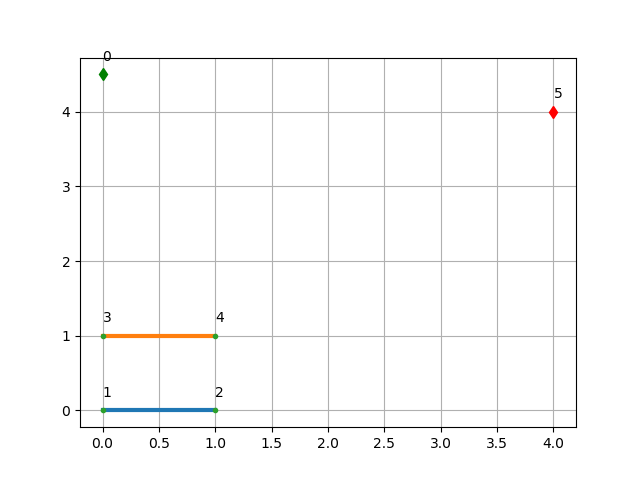

In [262]:
# Starting point
xs = np.array([0.])[np.newaxis]
ys = np.array([4.5])[np.newaxis]

# Coordinates for N lines
Nlines = 2
x1s = np.arange(Nlines)[np.newaxis].T
y1s = np.zeros((Nlines,1))
x2s = np.arange(Nlines)[np.newaxis].T 
y2s = np.ones((Nlines,1))

# Ending point
xe = np.array([4.0])[np.newaxis]
ye = np.array([4.0])[np.newaxis]

x = np.concatenate((xs,x1s,x2s,xe),axis=0)
y = np.concatenate((ys,y1s,y2s,ye),axis=0)

def plot_lines(x,y):
    ''' A method to plot individual lines with start/end points.'''
    for i in np.arange(1,len(x)-1,2):    
        plt.plot(x[i:i+2],y[i:i+2],linewidth = 3)

    
    plt.plot(x,y,'.')
    plt.plot(x[-1],y[-1],'dr')
    plt.plot(x[0],y[0],'dg')

    plt.grid('True')
    
    # zip joins x and y coordinates in pairs
    z = 0
    for x1,y1 in zip(x,y):

        label = "{:d}".format(z)
        z = z +1
        plt.annotate(label, # this is the text
                     (x1,y1), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='left') # horizontal alignment can be left, right or center
    plt.show()
    
plt.figure()
plot_lines(x,y)


In the code above we created the starting point (green diamond), pairs of points for 4 lines, and and ending point (red diamond). We've concatinated these points into two arrays, x and y, and we can pre-calculate the distances between all pairs of points. This will allow us to lookup and sum "steps" along our route, where a step consists of traversing a line segment and then proceeding to the start of the next. 

In [263]:
xx, yy = np.meshgrid(x,y)
d = np.sqrt( (xx-xx.T)**2 + (yy-yy.T)**2)

This matrix, `d` will prove very useful. The distance from the `i`th point to the `j`th point can be found by indexing into `d` like this: `d[i,j]`.  

Next we need a method that, given a route, calculates the distance along that route. The route we will specify by an array of integers indicating where in the array of points we've created we are to to proceed to next.

Omitting the starting point for now, consider a move from the point at index 1, along the line formed by the points at index 1 and index 2, and then to the first point in the next line in our route. We will call these two segments, the length of the line to follow, plus the distance from the end of one line to the beginning of the text, a "step". 

To begin lets create an array of indices for all the points in our list. We will use this array to select points we need to consider for each step.

In [264]:
r = np.arange(len(x))

Now lets create a method that, when given the index of the point at which to start, will calculate the distance of a single step. We will pass in everything required to do the calculation too. 

In [265]:
def stepDistance(start,end,d):
    # Odd start indices indicate moving forward along the line, while even indicate moving backward.
    if np.mod(start,2) == 1:
        # distance of the line plus distance from the end of the line to the start of the next line.
        dist = d[start,start+1] + d[start+1,end]
    else:
        dist = d[start,start-1] + d[start-1,end]
        
    return dist


Next we need a method to calculate the entire distance given a route. But first we need to think about what a route means given this setup. If we were working on the traditional TSP problem every point would be considered as part of the route. But in this case some points are the start of a line, and some points are the end of a line and sometimes the line is traversed in one direction and sometimes it is traversed in the opposite direction. So how do we handle that?

What if we create a new table, that holds distances of steps, where steps may be backward or forward. We'll sort out later how to ensure a step passed in the forward direction is not redundantly also considered in the backward direction. 

Steps in the forward direction for each line will always start on odd indices (index 0 being the starting point for the whole route), and steps in the backward direction for each line will always start on even indices. Remember that each step consists of traversal along the line, (either forward or backward), plus the distance from the end point of the current line to the begining of the next line. 

So, for example, the entry in d[1,3] will be the sum of the length of the line segment from point 1 to point 2, plus the distance from point 2 to point 3, which is the start of our next line. 

We will also include in this table the distance from the starting point of the route (at index 0) to every possible point, since the beginning or ending of any line segment could be specified as the first line to traverse. Similarly we will include the distance from every possible point to the end point of the route, since the end of any line segment could be the final segment in the route and we need the distance from it to the route end. 


In [266]:
N = d.shape[0]
dd = np.empty((N,N)) + np.nan

fwd_start_indices = np.argwhere(np.mod(r,2) == 1)
bwd_start_indices = np.argwhere(np.mod(r,2) == 0)

# Indexing here can be confusing. "fwd_start_indices" should not include the final index
# because that includes the end point. 
for idx in fwd_start_indices[:-1]:
    # 
    for jdx in np.arange(N)[1:]:
        # Here we are calculating two things. We are calculating skip the first index and last one, because these points and
        # are not included in valid "steps" as we've defined them. Then we 
        # also omit when jdx == idx, because this step starts and ends at the same
        # point. Finally we omit when the end point is just one more than the 
        # start point, because our "step" requires it to be at least 2 points later. 
        # [One point later is just as the end of the current line, but not the start of the next.]
        
        # Capture distance from any given point to the end point. 
        if jdx == (N-1):
            dd[idx,jdx] = d[idx,jdx]
        # Capture the distance from any point moving along a line in a forward direction. 
        elif jdx != N-1 and jdx != idx and jdx != (idx+1):
            dd[idx,jdx] = stepDistance(idx,jdx,d)
            # Capture the length of the line.
        elif jdx == (idx + 1):
            dd[idx,jdx] = d[idx,jdx]
       
for idx in bwd_start_indices:
    for jdx in np.arange(N)[1:]:
        # Capture the distance from the first point to the start or end of any line.
        # and the distance from the end of any line to the end point.
        if idx == 0 or jdx == (N-1):
            dd[idx,jdx] = d[idx,jdx]
        # Capture the distance going backward along any line. 
        elif jdx != idx and jdx != (idx-1):
            #if jdx != N-1 and jdx != idx and jdx != (idx-1):
            dd[idx,jdx] = stepDistance(idx,jdx,d)
            # Capture the length of each line (redundant to the forward direction)
        elif jdx == (idx-1):            
            dd[idx,jdx] = d[idx,jdx]


Here is our table of distances for each step, and a plot of the table and the points so we can ensure this is correct.

In [267]:
print(dd)


[[       nan 4.5        4.60977223 3.5        3.64005494 4.03112887]
 [       nan        nan 1.         2.41421356 2.         5.65685425]
 [       nan 1.                nan 2.         2.41421356 5.        ]
 [       nan 2.41421356 2.                nan 1.         5.        ]
 [       nan 2.         2.41421356 1.                nan 4.24264069]
 [       nan        nan        nan        nan        nan        nan]]


<IPython.core.display.Javascript object>


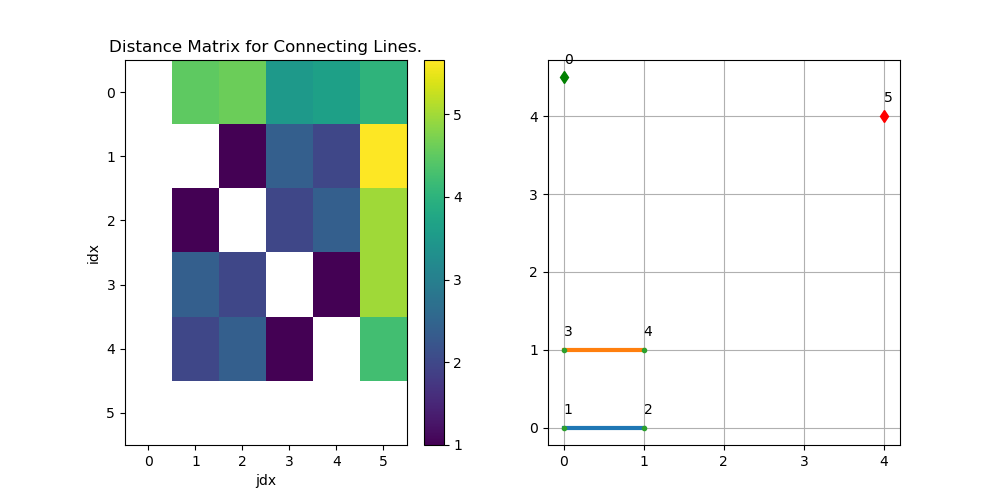

In [268]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(dd)
plt.xlabel('jdx')
plt.ylabel('idx')
plt.title('Distance Matrix for Connecting Lines.')
plt.colorbar()
plt.axis('equal')
plt.axis('tight')

plt.subplot(122)
plot_lines(x,y)
plt.show()


Ok, given these results, lets see if it makes any sense. Consider the step that consists of the first line going in the forward direction and ending at the seocnd line, also going in the forward direction. The index for the start of the first line is 1. The index of the start of the second line is 3. So idx = 1 and jdx = 3. The length of the first line is 1, and the distance from the end of the first line to the start of the second line in the forward direction is 1.4, so the value at idx=1, jdx=3 should be 2.4. Inspecting the distance matrix we see it is!.

Let us check another one. Consider the step that goes from the end of the first line, backwards along the first line to the start of the second line. The index corresponding to the end of the first line is 2, and the index of the start of the second line is 3. So idx = 2, and jdx =3. The distance backward along the first line is 1 and the distance from the beginning of the first line to the beginning of the second line is 1, so the sum is 2. And indeed the box at idx=2,jdx=3 is 2. 

Great! Now we have a way to calculate the lengh of any step along the route, where a step consists of traversing a line in some direction and then transiting from the line to the beginning of the next line. 

Let us capture this in a function for easy use later.

In [269]:
def generate_distance_table_for_lines(x,y):
    ''' Generate a distance table from a list of coordinates for a start point, 
    a series of lines, and an end point.
    
    idx/jdx:  0   1    2    3    4   5
        x = [xs p1x1 p1x2 p2x1 p2x2 xe]
        y = [ys p1y1 p1y2 p2y1 p2y2 ye]
    
    Where
    
    (xs,ys) is the starting point.
    
    (p1x1,p1y1) -- (p1x2,p1y2) are two points that define the first line segment.
    (p2x1,p2y1) -- (p2x2,p2y2) are two points the define the second line segment.
    Additional line segmenets are specified in the same way.
    
    (xe,ye) is the ending point.
    
    The table is indexed by the starting point of one line, idx, and 
    the starting point of a subsequent line, jdx.
    
    The table value at dd[idx,jdx] is the sum of the length of the line starting 
    at idx, and the distance from the end of the line starting at idx to the start 
    of the line specified by jdx. 
    
    Note that when idx is odd, this implies the line is traversed in the 
    forward direction, meaning that the "end" of the line is specified by the 
    point at idx+1. Similarly when idx is even, this implies the line is 
    traversed in the backward direction, meaning that the "end" of the line
    is specified by the point at idx -1. 
    
    The table also provides the length of each line, which can 
    be obtained by specifying indices for the points at either end. For 
    example, dd[1,2] will provide he length of the first line.
    
    Finally, the table also holds the distance from the starting point to either
    end of every line, and similarly from the ending point to either end of every 
    line. These are indexed with dd[0,i] and dd[i,N-1], where i is the index to/from
    the desired point and N is the number of points.  
    
    '''
    
    # First calculate the distance between all pairs of points
    xx, yy = np.meshgrid(x,y)
    d = np.sqrt( (xx-xx.T)**2 + (yy-yy.T)**2)
    
    #print(d)
    N = d.shape[0]
    
    # Initalize the result.
    dd = np.empty((N,N)) + np.nan

    # Get indices for steps that go in the forward direction of each line
    # and those that go in the backward direction too. 
    r = np.arange(len(x))
    fwd_start_indices = np.argwhere(np.mod(r,2) == 1)
    bwd_start_indices = np.argwhere(np.mod(r,2) == 0)

    #print(fwd_start_indices)
    #print(bwd_start_indices)
    # Indexing here can be confusing. "fwd_start_indices" should not include the final index
    # because that includes the end point. 
    for idx in fwd_start_indices[:-1]:
        # 
        for jdx in np.arange(N)[1:]:
            # Here we are calculating two things. We are calculating skip the first index and last one, because these points and
            # are not included in valid "steps" as we've defined them. Then we 
            # also omit when jdx == idx, because this step starts and ends at the same
            # point. Finally we omit when the end point is just one more than the 
            # start point, because our "step" requires it to be at least 2 points later. 
            # [One point later is just as the end of the current line, but not the start of the next.]

            # Capture distance from any given point to the end point. 
            if jdx == (N-1):
                dd[idx,jdx] = d[idx,jdx]
            # Capture the distance from any point moving along a line in a forward direction. 
            elif jdx != N-1 and jdx != idx and jdx != (idx+1):
                dd[idx,jdx] = stepDistance(idx,jdx,d)
                # Capture the length of the line.
            elif jdx == (idx + 1):
                dd[idx,jdx] = d[idx,jdx]

    for idx in bwd_start_indices:
        for jdx in np.arange(N)[1:]:
            # Capture the distance from the first point to the start or end of any line.
            # and the distance from the end of any line to the end point.
            if idx == 0 or jdx == (N-1):
                dd[idx,jdx] = d[idx,jdx]
            # Capture the distance going backward along any line. 
            elif jdx != idx and jdx != (idx-1):
                #if jdx != N-1 and jdx != idx and jdx != (idx-1):
                dd[idx,jdx] = stepDistance(idx,jdx,d)
                # Capture the length of each line (redundant to the forward direction)
            elif jdx == (idx-1):            
                dd[idx,jdx] = d[idx,jdx]
                
    return dd

The next step is to create a funcion to calculate the length of an entire route. A route will be speciifed as a sequence of steps. When a step begins on an odd index it indicates we will traverse the line in the forward direction and when it begins on an even index it indicates we will travers the line in the backward direction. 

How we generate the route requires more discussion, but for now lets generate one synthetically. Every route will start with the index of the starting point at index 0, and end with the ending point (N-1). Indices indicating the sequence of steps will fall between.

In [103]:
route = np.array([0, 1, 3, 2*Nlines+1])

Calculation of the distance along the route is a little trick and so we'll do it step-wise. We first start with the distance from the starting point to the start of the first line. Next we add the distance of each "step" where, again, a step is the length of the line plus the distance to the next line and these are added up for all full "steps" we can take. This leaves the length of the last and the distance from which ever end of the last line we ended on to the end of the route. This is captured in `routeDistance` below using the table of distances created above.

In [104]:
def routeDistance(route,dd):
    # First point to start of first line.
    dist = dd[route[0],route[1]]
    
    # Steps consisting the length of each line plus transit to the next, ending at the beginning of the last line.
    dist += np.sum(dd[route[1:-2],route[2:-1]])
    
    # For forward going lines (odd indices)
    # add the length of the last line plus the distance
    # from the end of the last line to the end point.
    if np.mod(route[-2],2) == 1:
        dist += dd[route[-2],route[-2]+1]
        dist += dd[route[-2]+1, route[-1]]
    # for backward going lines (even indices)
    # add the length of the last line plus the
    # distance to the end point.
    else:
        dist += dd[route[-2],[route[-2]-1]]
        dist += dd[route[-2]-1,route[-1]]
    return dist

Now lets check this calculation with a our example route and maybe a few others. Our example route passes along each of the two lines in the forward direction. It is the route shown in the plot above. The distance from the start point to the start of the first line is 4.5. The distance along the first line is 1. The distance from the end of the first line to the start of the second is about 1.4. The distance along the second line is 1, and finally the distance from the end of the second line to the end point is about `3*1.4`. Adding these up gives the same result!

In [105]:
rd = routeDistance(route,dd)
print(rd)
print(4.5 + 1 + 1.4 + 1 + 3*1.4)

12.15685424949238
12.1


Ok, now lets create another route and check that one too. This time we'll go forward along the first line, but backward along the second line. 

In [106]:
route = np.array([0,1,4,2*Nlines+1])

In [107]:
print(route)
rd = routeDistance(route,dd)
print(rd)

[0 1 4 5]
[12.5]


Checking this one, the distance from the start to the starting point is 4.5. The length of the first line is 1.0 The distance from the end of the first line to the end of the second line (since we're traversing it backward) is 1, the length of the second line is 1 and, finally, the distance from the beginning of the second line to the end point is `sqrt( (4-1)**2 + (4-0)**2)`. This gives:

In [108]:
print(4.5 + 1.+ 1. + 1. + np.sqrt( (4-1)**2 + (4-0)**2))

12.5


Great! Ok so now on to how we generate routes. 

First we consider the properties of a valid route. A valid route must start with the starting point and end with the ending point, that much is clear. 

It is useful to remember a forward step along a line is indicated by an index in the route with an odd index while a backward step along a line is indicated by an even index. 

A forward step's destination cannot be the end of its own line, so a valid route cannot have two sequential indices in which the first, `i`, is odd and the second is `i + 1`. Similarly, a backward step's destination cannot be the beginning of its own line, so a valid route cannot have two sequential indices in which the first index, `i` is even and the second is `i-1`. 

We also have to remember that we only want to traverse a given line once. So if we've traversed a line forward fronm index, `i`, we don't want to subsequently travese the same line backward from `i+1`. 

As a check, one can note that the number of indices in the final route should be the number of lines, `Nlines` + 2.

The strategy I will take is to first start with a random array of indices for each point in each line (that is indices for all points omitting the start point and the end point). We'll call this array rc for "candidate route".

In [109]:
cr = np.random.permutation(np.arange(len(x)-2))+1
print(cr)

[4 2 3 1]


Next I'm going to build a valid route by seeding an empty list with the first point in my candidate route, and then step through the candidate route noting which indices are invalid because of previously selected points. As mentioned above, these will be the next point in lines we are traversing in the forward direction and the previous point for lines we are traversing in the reverse direction. 

Finally one can assemble the final route by concatinating indies for the first point and last point to this new route.

In [110]:
r = [cr[0]]
if np.mod(cr[0],2)==1:
    invalid_indices = [cr[0] + 1]
else:
    invalid_indices = [cr[0]-1]

for idx in np.arange(len(cr)):
    # Forward steps.
    if (idx != 0 and np.mod(cr[idx],2) == 1) and cr[idx] not in invalid_indices:
        r.append(cr[idx])
        # End of its own line.
        invalid_indices.append(cr[idx]+1)

    # backward steps
    elif (idx != 0 and idx != (len(cr)-1) and 
          np.mod(cr[idx],2) == 0) and cr[idx] not in invalid_indices:
            r.append(cr[idx])
            # Beginning of its own line.
            invalid_indices.append(cr[idx]-1)
print(r)        
print(invalid_indices)
route = [0] + r + [len(cr) + 1]
print("route:")
print(route)


[4, 2]
[3, 1]
route:
[0, 4, 2, 5]


One can plot the route and verify that it looks asit one expects. To do this we generate a method to correctly index the end-points of each line in the order specified by the route, inserting the ends of lines as appropriate.

In [272]:
def route_by_points(route):
    ''' Generate the full route by inserting indices for the missing points for each line. '''
    ii = []
    for idx in route:
        ii.append(idx)
        if np.mod(idx,2) == 1 and idx != route[-1]:
            ii.append(idx+1)
        else:
            if idx != 0 and idx != route[-1]:
                ii.append(idx-1)
    return ii

ii = route_by_points(route)
print(ii)

def plot_route(ii,x,y):
    
    plt.plot(x[ii],y[ii],':k')
    plt.plot(x[0],y[0],'dg')
    plt.plot(x[-1],y[-1],'dr')
    plt.grid('True')
    plt.show()
    

[0, 4, 3, 2, 1, 5]


<IPython.core.display.Javascript object>


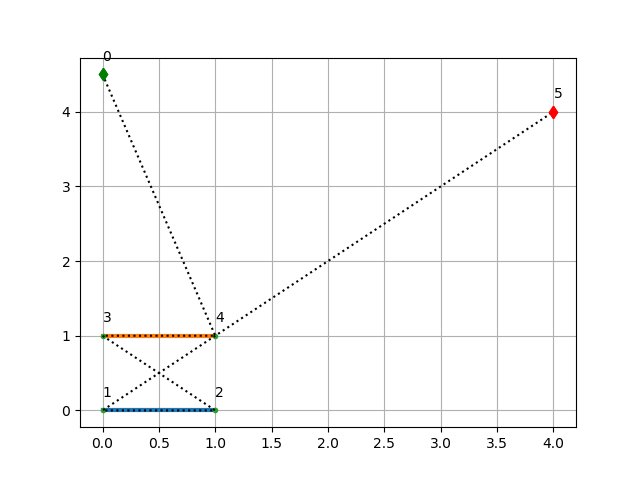

In [273]:
route_pts = route_by_points(route)
plt.figure()
plot_lines(x,y)
plot_route(route_pts,x,y)


The route valididation procedure above should be condensed into a method. Let us do that now:

In [218]:
def generate_valid_route(cr):
    ''' Given a candidate route of return a valid route connecting lines.'''
    r = [cr[0]]
    '''
    if np.mod(cr[0],2)==1:
        invalid_indices = [cr[0] + 1]
    else:
        invalid_indices = [cr[0]-1]
    '''
    invalid_indices = []

    for idx in np.arange(len(cr)):
        # Forward steps.
        if (idx != 0 and 
            idx != len(cr)-1 and
            np.mod(cr[idx],2) == 1 and 
            cr[idx] not in invalid_indices):
            
            r.append(cr[idx])
            # End of its own line.
            invalid_indices.append(cr[idx]+1)

        # backward steps
        elif (idx != 0 and 
              idx != (len(cr)-1) and 
              np.mod(cr[idx],2) == 0 and 
                cr[idx] not in invalid_indices):
            
                r.append(cr[idx])
                # Beginning of its own line.
                invalid_indices.append(cr[idx]-1)
    
    r = [x for x in r if x not in invalid_indices]
    # Concatinate route and end point.
    route = r + [len(cr)-1]

    return route

The next task is to modify a classic TSP algorithm, "two-opt" to find solutions for lines rather than points using our work thus far. Here is the algorithm for points from which we'll make modifications. This method is modified from a [stack-overflow](https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy) post implementing the classic two_opt algorithm. 

We should be mindful that the two_opt algorithm is not guaranteed to give the optimal solution, and that there are many other approximate TSP solutions in the literature. 

    # Calculate the euclidian distance in n-space of the route r traversing cities c, ending at the path start.
    #path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])
    # Reverse the order of all elements from element i to element k in array r.
    two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))


    def two_opt(xs,ys,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt

        #xx = [p.position.x for p in cities]
        #yy = [p.position.y for p in cities]

        xx, yy = np.meshgrid(xs,ys)
        dd = np.sqrt( (xx-xx.T)**2 + (yy-yy.T)**2)

        #print(dd)

        route = np.arange(dd.shape[0]) # Make an array of row numbers corresponding to cities.
        improvement_factor = 1 # Initialize the improvement factor.
        #best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
        best_distance = np.sum(dd[route[:-1],route[1:]])


        while improvement_factor > improvement_threshold: # If the route is still improving, keep going!

            distance_to_beat = best_distance # Record the distance at the beginning of the loop.

            for swap_first in range(1,len(route)-2): # From each city except the first and last,

                for swap_last in range(swap_first+1,len(route)): # to each of the cities following,

                    new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                    #print(new_route)
                    #new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                    new_distance = np.sum(dd[new_route[:-1],new_route[1:]])

                    #print("%0.3f, %0.3f" % (new_distance, best_distance))
                    if new_distance < best_distance: # If the path distance is an improvement,
                        route = new_route # make this the accepted best route
                        best_distance = new_distance # and update the distance corresponding to this route.
                improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
                # print("d:%0.3f, if: %0.3f" % (best_distance,improvement_factor))

        return route # When the route is no longer improving substantially, stop searching and return the route.

Here is the further modified two_opt function, `two_opt_lines`, to solve our line-segment TSP problem.

The method first pre-calculates the table of distances for steps along the route. 

The route under consideration is represented in two ways - as a "route" which is a series of indices where each index represents a "step", as we've defined it above, and as a "point_route" which includes the points omitted by the step-wise representation, namely, the end points of each line-segment. The reason for these two reprentations will be made clear momentarily.

The basic strategy of two-opt swap algorithm is to reverse the order of a subset of of the existing route, and testing the distance against the best route identified thus far. By reversing the order, one effectively "unwraps" crossing portions of the route, producing a new route that is more direct. The lambda function `two_opt_wap` does this permutation. 

Permuations of a route must occur on the point-wise representation of the route because the step-wise representation only contains the starting points of each line. Ending points must be considered because they indicate traversal of the line in the reverse direction. 

Once a permutation is calculated from the point-wise representation, the resulting route may be invalid. Invalid routes occur when, for example, a line-segment's two points are no longer adjacent to each other. Our method `generate_valid_route` will produce a valid step-wise route given the new permutation in the point-wise representation. 

The step-wise representation of the route is passed to `routeDistance()` to return the length of that candidate route. 

The process of systematically permuting the route and testing its length against our best length is continued until the desired improvement threshold is reached. 

>NOTE: Our solution below contains some debugging print statements that can be removed in a final solutoin. 


In [275]:
# Calculate the euclidian distance in n-space of the route r traversing cities c, ending at the path start.
#path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])
# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))


def two_opt_lines(xs,ys,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
    

    dd = generate_distance_table_for_lines(xs,ys)
    
    # Generate a candidate route from the individual points. 
    point_route = np.arange(len(xs))
    # Make sure the route is valid, in part, by dropping implied points.
    route = generate_valid_route(point_route)

    improvement_factor = 1 # Initialize the improvement factor.
    best_distance = routeDistance(route,dd)

    print(route)
    print("Initial Distance: %0.2f" % best_distance)
    
    # Begin the search.
    while improvement_factor > improvement_threshold: # If the route is still improving, keep going!

        distance_to_beat = best_distance # Record the distance at the beginning of the loop.
    
        for swap_first in range(1,len(point_route)-2): # From each point except the first and last,
        
            for swap_last in range(swap_first+1,len(point_route)-1): # to each of the points following,
                
                # try reversing the order of these points.
                # Note, when two indices are non-sequential, this will reverse the 
                # order of the lines. When two indices are sequential, it will reverse
                # the direction of the line. 
                new_candidate_point_route = two_opt_swap(point_route,swap_first,swap_last) 

                # Our candidate route will likely not be valid. It will specify a point at the 
                # end of one line without specifying its pair at the other end of the line next.
                # generate_valid_route will enforce this. 
                # NOTE: This step may be controversial, because in dropping invalid points
                # I may be making some permutations unattainable. It may be impossible to "swap"
                # my way to some portions of the search area. Need to think about this more.
                new_route = generate_valid_route(new_candidate_point_route)
                # generate_valid_route will return a condensed route, only specifying the start 
                # of each line to traverse. This is used in our function to calculate the route
                # length. But subsequent permutations require the full list of points to traverse,
                # which is provided from the cendensed route by route_by_points. 
                new_point_route = route_by_points(new_route)

                # and check the total distance with this modification.
                new_distance = routeDistance(new_route,dd)

                print("new route %0.2f:" % new_distance)
                print(new_route)
         
                if new_distance < best_distance: # If the path distance is an improvement,
                    point_route = new_point_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
                    print("New best route: %0.2f" % new_distance)
                    print(new_route)

            improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
            print("Dist: %0.3f, improvement factor: %0.3f" % (best_distance,improvement_factor))
            print(new_route)
    
    route = generate_valid_route(point_route)
    
    return route # When the route is no longer improving substantially, stop searching and return the route.

Now lets test our solution. We'll generate 20 random points. The first point will be our starting point, and our final point will be our ending point and the 18 points will designate 9 lines that we are to traverse, in any order.  

<IPython.core.display.Javascript object>


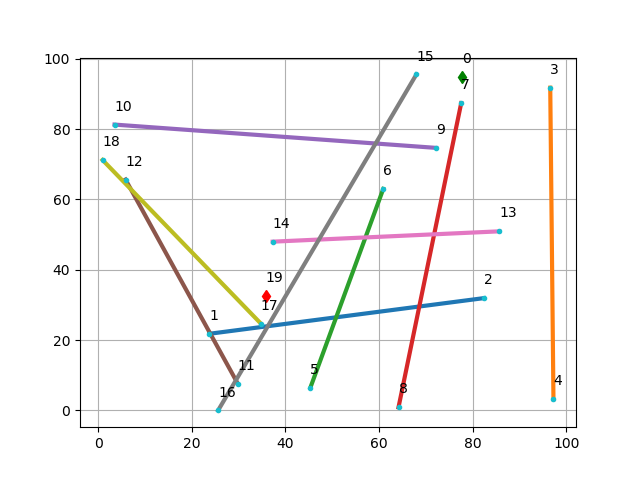

In [276]:
np.random.seed(13)
x = np.random.random((20,1))*100
y = np.random.random((20,1))*100

plt.figure()
plot_lines(x,y)


In [278]:
ii = two_opt_lines(x,y,.01)

[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
Initial Distance: 1239.41
new route 1251.16:
[0, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19]
new route 1112.86:
[0, 3, 2, 5, 7, 9, 11, 13, 15, 17, 19]
New best route: 1112.86
[0, 3, 2, 5, 7, 9, 11, 13, 15, 17, 19]
new route 1257.73:
[0, 1, 4, 5, 7, 9, 11, 13, 15, 17, 19]
new route 1206.96:
[0, 5, 1, 4, 7, 9, 11, 13, 15, 17, 19]
new route 1119.89:
[0, 6, 1, 4, 7, 9, 11, 13, 15, 17, 19]
new route 1089.55:
[0, 7, 6, 1, 4, 9, 11, 13, 15, 17, 19]
New best route: 1089.55
[0, 7, 6, 1, 4, 9, 11, 13, 15, 17, 19]
new route 1085.10:
[0, 3, 2, 5, 8, 9, 11, 13, 15, 17, 19]
New best route: 1085.10
[0, 3, 2, 5, 8, 9, 11, 13, 15, 17, 19]
new route 1176.70:
[0, 9, 7, 6, 1, 4, 11, 13, 15, 17, 19]
new route 1170.70:
[0, 10, 7, 6, 1, 4, 11, 13, 15, 17, 19]
new route 1064.27:
[0, 11, 10, 7, 6, 1, 4, 13, 15, 17, 19]
New best route: 1064.27
[0, 11, 10, 7, 6, 1, 4, 13, 15, 17, 19]
new route 1012.15:
[0, 3, 2, 5, 8, 9, 12, 13, 15, 17, 19]
New best route: 1012.15
[0, 3, 2, 5, 8, 9,

Before we inspect our result, lets look at the output above and see what's happening. The first route consists of the odd indices from our list of input points, which means we are to traverse the lines in the order they were specified, and because all indicies are odd, all alines are to be traversed in the forward direction. 

    [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    Initial Distance: 1239.41
    
This is our new route after the first pemutation and its length, which is worse than our initial route, so it is not retained. The index at location 1 has switched from "1" to "2". This means tha route is identical to the previous one, but the first line is traversed in the backward direction.:

    new route 1251.16:
    [0, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19]

The next route does improve on our initial route. The indexes at locations 1 and 2 ("3" and "2" respectively) have been swapped. Now the second line segment is being traversed prior to the first line segment and, as before, the first line segment is being traversed backward. This new route is identified as a new best route and we print it out again for emphasis:

    new route 1112.86:
    [0, 3, 2, 5, 7, 9, 11, 13, 15, 17, 19]
    New best route: 1112.86
    [0, 3, 2, 5, 7, 9, 11, 13, 15, 17, 19]
    
The process of permuting the route continues until the improvement threshold drops below the specified value. 

Lets now plot up the most optimal route we've found thus far. 

<IPython.core.display.Javascript object>


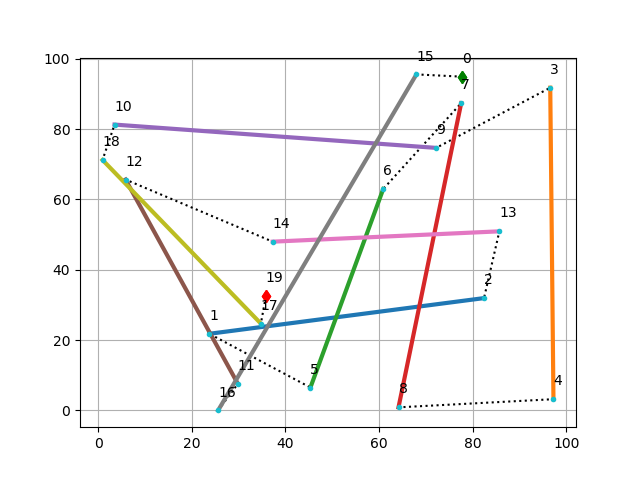

In [279]:
iii = route_by_points(ii)
plt.figure()
plot_route(iii,x,y)
plot_lines(x,y)

In [280]:
ii

[0, 15, 11, 14, 2, 5, 7, 4, 9, 18, 19]

In [281]:
iii

[0, 15, 16, 11, 12, 14, 13, 2, 1, 5, 6, 7, 8, 4, 3, 9, 10, 18, 17, 19]